In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

dataset_path = r"..\..\datasets\btc_options_data\european_btc_calls.csv"
european_calls = pd.read_csv(dataset_path)

In [3]:
# Defining now, as it comes in handy :)
def evaluate_model(true, predicted, model_name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    percent_error = np.abs((true - predicted) / true) * 100
    pe5 = np.mean(percent_error <= 5) * 100  # Percentage of predictions within 5% error
    pe10 = np.mean(percent_error <= 10) * 100  # Percentage of predictions within 10% error
    pe20 = np.mean(percent_error <= 20) * 100  # Percentage of predictions within 20% error

    
    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  PE5: {pe5:.2f}%")
    print(f"  PE10: {pe10:.2f}%")
    print(f"  PE20: {pe20:.2f}%")

# As seen in the Brazilian Options Data, it is crucial to separate the options by Moneyness.
def classify_moneyness(row):
    if row['MONEYNESS'] > 1.05:  # ITM: S/K > 1.05
        return 'ITM'
    elif 0.95 <= row['MONEYNESS'] <= 1.05:  # ATM: 0.95 <= S/K <= 1.05
        return 'ATM'
    else:  # OTM: S/K < 0.95
        return 'OTM'

european_calls['MONEYNESS_CATEGORY'] = european_calls.apply(classify_moneyness, axis=1)

# Because we have concentrations of data on very different premium values
# (and, as we will see later, ITM, ATM, OTM is significant), we use stratified shuffle split
# Again, I splitted it with the Moneyness Category in mind
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(european_calls, european_calls['MONEYNESS_CATEGORY']):
    train_data = european_calls.iloc[train_idx]
    test_data = european_calls.iloc[test_idx]

# Our data does not have a Risk Free Rate column, which is essential for Black-Scholes calculation;
# Since we are solving the same problem B-S solves, I chose to include in it
risk_free_rate = 0.0431  # https://www.cnbc.com/quotes/US1Y
train_data['RISK_FREE_RATE'] = risk_free_rate
test_data['RISK_FREE_RATE'] = risk_free_rate

# Handle outliers in NEGOTIATED_PRICE
price_upper_limit = train_data['NEGOTIATED_PRICE'].quantile(0.99)
price_lower_limit = train_data['NEGOTIATED_PRICE'].quantile(0.01)
train_data['NEGOTIATED_PRICE'] = train_data['NEGOTIATED_PRICE'].clip(lower=price_lower_limit, upper=price_upper_limit)

# A few other metrics that might be useful, as they come up a lot in Options Theory
train_data['INTRINSIC_VALUE'] = np.maximum(train_data['UNDERLYING_PRICE'] - train_data['STRIKE'], 0)
test_data['INTRINSIC_VALUE'] = np.maximum(test_data['UNDERLYING_PRICE'] - test_data['STRIKE'], 0)

train_data['RELATIVE_IV'] = train_data['MARK_IV'] / train_data['MONEYNESS']
test_data['RELATIVE_IV'] = test_data['MARK_IV'] / test_data['MONEYNESS']

# Attention: these features are not the original ones. These are the result of analysing correlations to prevent
# issues such as multicollinearity.
features = [
    "UNDERLYING_PRICE",
    "DTE",
    "MARK_IV",
    "MONEYNESS",
    "DELTA",
    "THETA",
]

target = 'NEGOTIATED_PRICE'

# Drop MONEYNESS_CATEGORY (it is a String)
train_data = train_data.drop(columns=['MONEYNESS_CATEGORY'])
test_data = test_data.drop(columns=['MONEYNESS_CATEGORY'])

# Scale features with RobustScaler;
# Similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.
# https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler
scaler = RobustScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data[target]
y_test = test_data[target]


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8864\3750477079.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8864\3750477079.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8864\3750477079.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [4]:
# ------------------------- MLP Model ------------------------- #
# I already know from literature the reasonableness of using MLP in this type of data, so I don't really bother
# and will go directly to Hyperparameter Tuning. 
mlp = MLPRegressor() 

param_distributions = {
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'hidden_layer_sizes': [(128, 64), (64, 32), (128, 128)],
    'alpha': [0.0001, 0.01, 0.1],
    'activation': ['relu', 'tanh']
}

# Randomized Search is better, as 1) it's faster, 2) I don't want to destroy my laptop.
random_search = RandomizedSearchCV( 
    estimator = mlp,
    param_distributions=param_distributions,
    n_iter = 15,
    scoring = "neg_mean_squared_error",
    random_state = 42,
    verbose = 2,
    n_jobs = -1
    
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_params)

best_mlp = random_search.best_estimator_
mlp_predictions = best_mlp.predict(X_test)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
16 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perce

Best Hyperparameters:
{'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 128), 'alpha': 0.01, 'activation': 'relu'}


C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [5]:
"""
Hyperparameters:
{'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 128), 'alpha': 0.01, 'activation': 'relu'}

"""

# Just not to write too much later:
mlp = best_mlp

# Evaluation:
evaluate_model(y_test, mlp_predictions, "MLP")


MLP Performance:
  MSE: 231231.5801761664
  MAE: 206.44558747091367
  R^2: 0.9980681794370522
  PE5: 53.23%
  PE10: 64.75%
  PE20: 73.94%



Residuals Analysis:
Mean Residual: 51.5381528005726
Standard Deviation of Residuals: 478.1871063778604


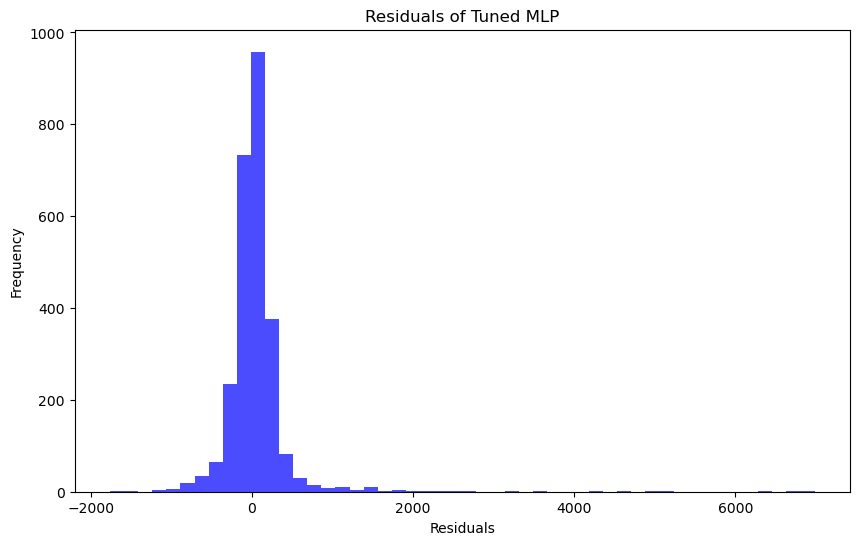

In [6]:
# Also check on residuals
residuals = y_test - mlp_predictions
print("\nResiduals Analysis:")
print("Mean Residual:", residuals.mean())
print("Standard Deviation of Residuals:", residuals.std())

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='blue', alpha=0.7)
plt.title('Residuals of Tuned MLP')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

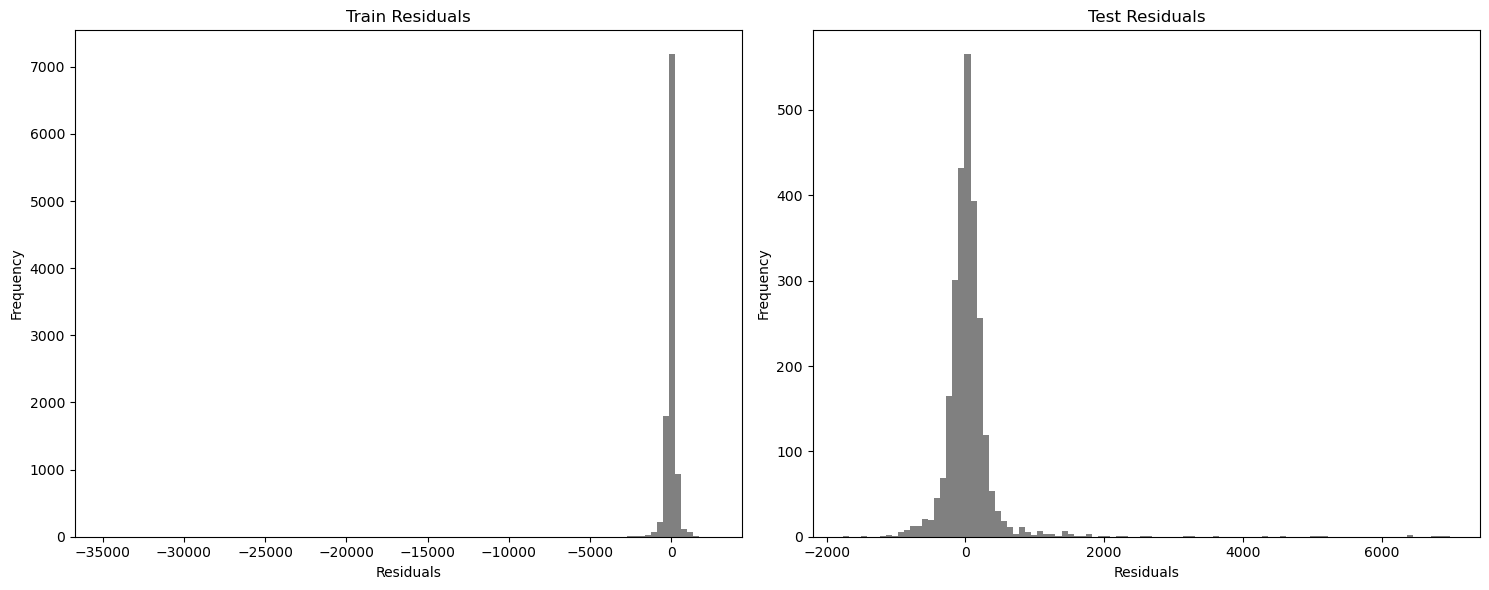

In [7]:
# The residuals are around 0, which is good enough.
# I want to check if the model is overfitting in any form. 
# First, I'll start by checking the residuals of test/train sets.

train_predictions = mlp.predict(X_train)
train_residuals = y_train - train_predictions

test_residuals = y_test - mlp_predictions

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
plt.hist(train_residuals, bins = 100, color = 'gray')
plt.title("Train Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_residuals, bins = 100, color = 'gray')
plt.title("Test Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")


plt.tight_layout()
plt.show() # I don't want a bunch of arrays showing up

So far, good enough. The model does not seem to overfit nor to be very overperformed by neither sets. The last metric I'll check is the Learning curve.

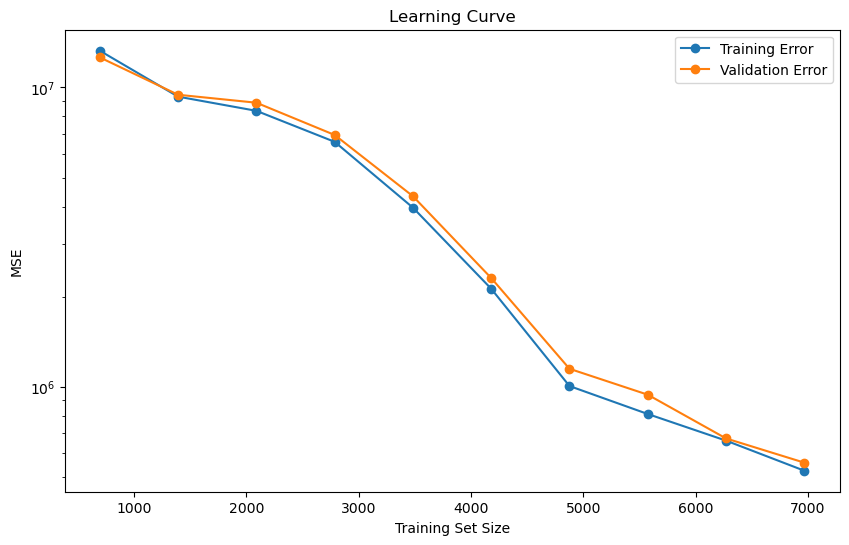

In [8]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_mlp,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Negative MSE to positive
train_scores_mean = -np.mean(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.plot(train_sizes, valid_scores_mean, label='Validation Error', marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.yscale("log")
plt.ylabel('MSE')
plt.legend()
plt.show()


The model is definitely not overfitting, as they decrease the MSE together and the gap between them is quite minimal.

In [9]:
# Stratified Split, again.
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# Just being redundant, as I somehow faced a few bugs related to this when running this code
european_calls['MONEYNESS_CATEGORY'] = european_calls['MONEYNESS'].apply(lambda x: 'ITM' if x > 1.05 else 'ATM' if 0.95 <= x <= 1.05 else 'OTM')

for train_idx, test_idx in stratified_split.split(european_calls, european_calls['MONEYNESS_CATEGORY']):
    train_data = european_calls.iloc[train_idx]
    test_data = european_calls.iloc[test_idx]

# Drop the ITM, OTM, ATM strings
train_data = train_data.drop(columns=['MONEYNESS_CATEGORY'])
test_data = test_data.drop(columns=['MONEYNESS_CATEGORY'])

X_train = train_data[features]
X_test = test_data[features]
y_train = train_data[target]
y_test = test_data[target]

# I chose to make a Pipeline this time, because why not?
pca = PCA(n_components=0.95)  # Keep 95% of variance
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', pca)
])

X_train_pca = pipeline.fit_transform(X_train)
X_test_pca = pipeline.transform(X_test)

best_mlp.fit(X_train_pca, y_train)


C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.01, hidden_layer_sizes=(128, 128))

In [10]:
y_pred_train = mlp.predict(X_train_pca)
pca_predictions = mlp.predict(X_test_pca)

evaluate_model(y_test, pca_predictions, "MLP with PCA-Reduced Features")


MLP with PCA-Reduced Features Performance:
  MSE: 54090.1343320364
  MAE: 141.45702853686007
  R^2: 0.9995481048320665
  PE5: 54.57%
  PE10: 66.05%
  PE20: 74.05%


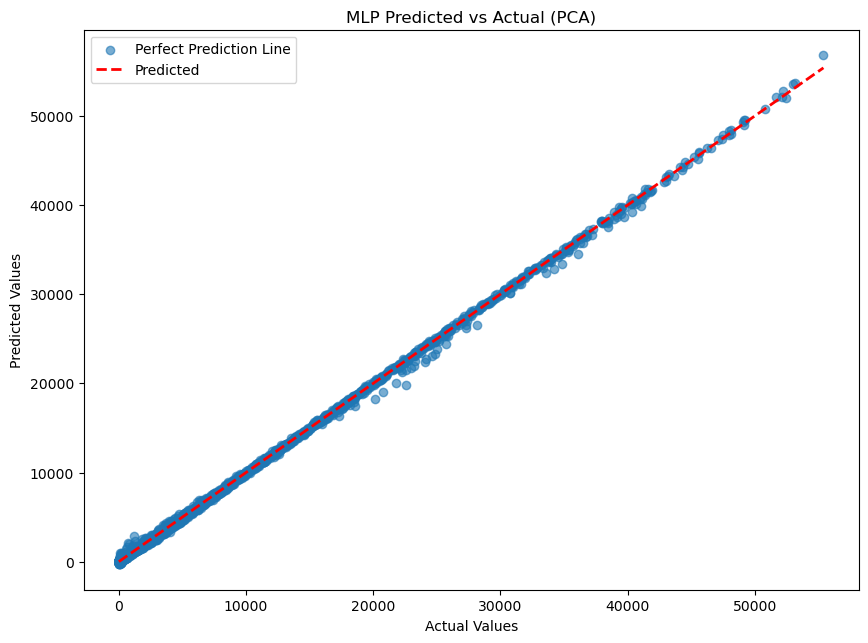

In [11]:
plt.figure(figsize=(10, 16))

plt.subplot(2,1,1)
plt.scatter(y_test, pca_predictions, alpha=0.6, label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
plt.title("MLP Predicted vs Actual (PCA)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend(["Perfect Prediction Line", "Predicted"])

The PCA model got WAY better compared to the simpler one - honestly, I am surprised! Now, let's go with the plots.

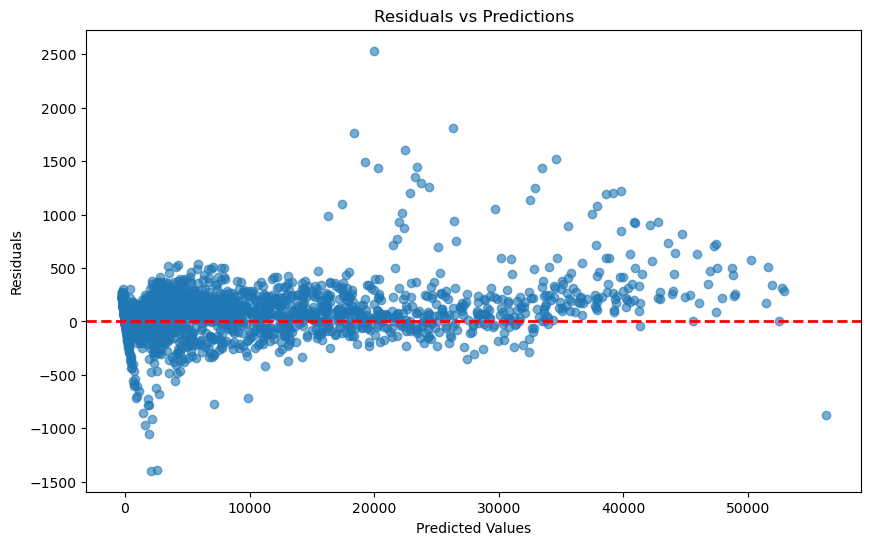

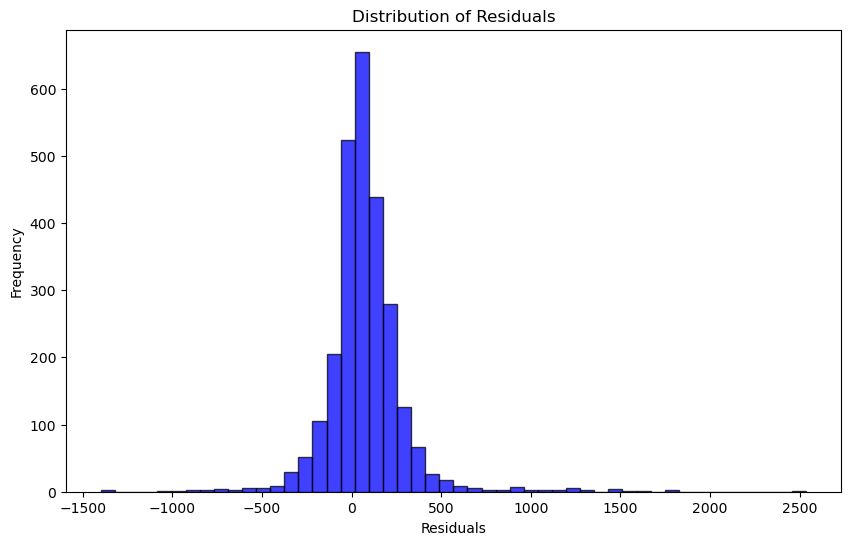

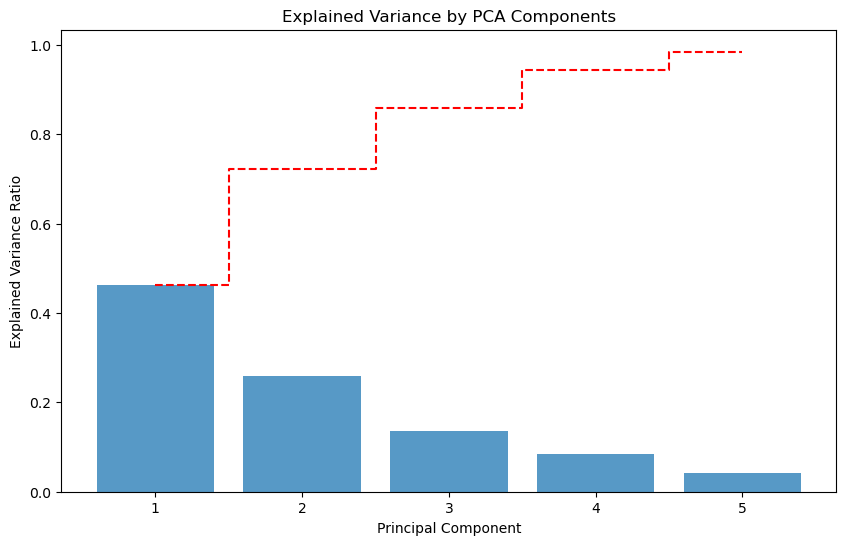

In [15]:
residuals = y_test - pca_predictions

# Residuals v. Predictions scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Residual Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# PCA Components Contribution
pca_components = pipeline.named_steps['pca'].components_
explained_variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Explained variance by PCA components
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.75, align='center')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', linestyle='--')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()


Now, we go on and test the model for OTM, ITM and ATM

In [16]:
# Segmented Modeling: Separate the data based on MONEYNESS (ITM, ATM, OTM)
# As seen in the Brazilian Options Data, it is crucial to separate the options by Moneyness.
def classify_moneyness(row):
    if row['MONEYNESS'] > 1.05:  # ITM: S/K > 1.05
        return 'ITM'
    elif 0.95 <= row['MONEYNESS'] <= 1.05:  # ATM: 0.95 <= S/K <= 1.05
        return 'ATM'
    else:  # OTM: S/K < 0.95
        return 'OTM'

european_calls['MONEYNESS_CATEGORY'] = european_calls.apply(classify_moneyness, axis=1)
# Add MONEYNESS category to the datasets
train_data['MONEYNESS_CATEGORY'] = train_data.apply(classify_moneyness, axis=1)
test_data['MONEYNESS_CATEGORY'] = test_data.apply(classify_moneyness, axis=1)

# Separate training data into segments
train_ITM = train_data[train_data['MONEYNESS_CATEGORY'] == 'ITM']
train_ATM = train_data[train_data['MONEYNESS_CATEGORY'] == 'ATM']
train_OTM = train_data[train_data['MONEYNESS_CATEGORY'] == 'OTM']

# Separate test data into segments
test_ITM = test_data[test_data['MONEYNESS_CATEGORY'] == 'ITM']
test_ATM = test_data[test_data['MONEYNESS_CATEGORY'] == 'ATM']
test_OTM = test_data[test_data['MONEYNESS_CATEGORY'] == 'OTM']


# Train separate models for each segment
segment_models = {}
segments = {'ITM': (train_ITM, test_ITM), 'ATM': (train_ATM, test_ATM), 'OTM': (train_OTM, test_OTM)}

for segment, (train_segment, test_segment) in segments.items():
    X_train_segment = train_segment[features]
    y_train_segment = train_segment[target]
    X_test_segment = test_segment[features]
    y_test_segment = test_segment[target]
    
    X_train_pca = pipeline.fit_transform(X_train_segment)
    X_test_pca = pipeline.transform(X_test_segment)
    
    mlp_model = MLPRegressor(**best_params)
    mlp_model.fit(X_train_pca, y_train_segment)
    
    segment_models[segment] = {
        'model': mlp_model,
        'pipeline': pipeline,
        'X_test': X_test_pca,
        'y_test': y_test_segment,
        'predictions': mlp_model.predict(X_test_pca)
    }

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
for segment, results in segment_models.items():
    y_test = results['y_test']
    predictions = results['predictions']
    evaluation = evaluate_model(y_test, predictions, segment)
    test_mape = mean_absolute_percentage_error(y_test, predictions)
    print(f"MAPE: {test_mape:.2f}%")
    print(evaluation)


ITM Performance:
  MSE: 14527026.456349488
  MAE: 2472.7351534991594
  R^2: 0.8903021303517459
  PE5: 27.46%
  PE10: 54.00%
  PE20: 83.18%
MAPE: 22.75%
None

ATM Performance:
  MSE: 79497.31937848484
  MAE: 184.65315078789135
  R^2: 0.9905609195699359
  PE5: 39.78%
  PE10: 53.71%
  PE20: 67.19%
MAPE: 56.33%
None

OTM Performance:
  MSE: 5663.679810254675
  MAE: 39.38987170297073
  R^2: 0.9987604536347875
  PE5: 48.43%
  PE10: 63.17%
  PE20: 72.82%
MAPE: 83.86%
None


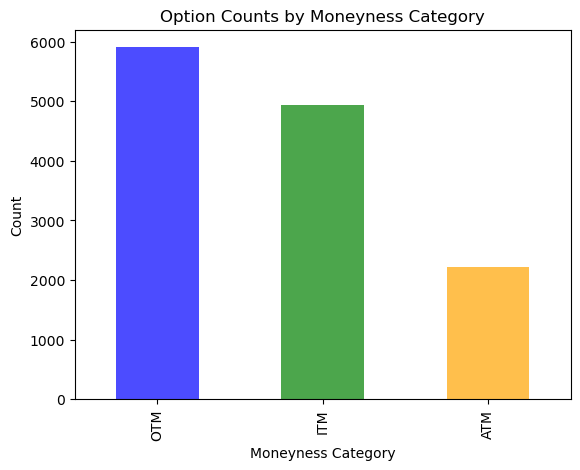

In [18]:
moneyness_counts = european_calls['MONEYNESS_CATEGORY'].value_counts()
moneyness_counts.plot(kind='bar', color=['blue', 'green', 'orange'], alpha=0.7)
plt.title("Option Counts by Moneyness Category")
plt.xlabel("Moneyness Category")
plt.ylabel("Count")
plt.show()


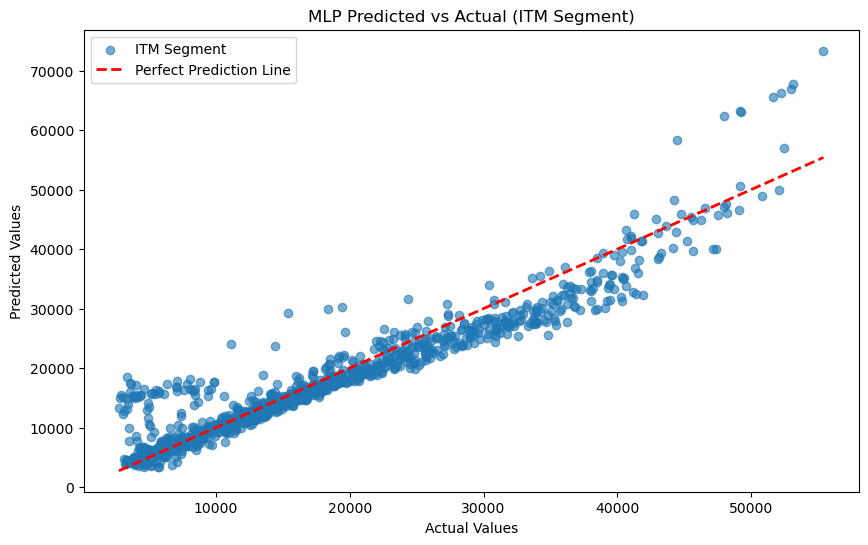

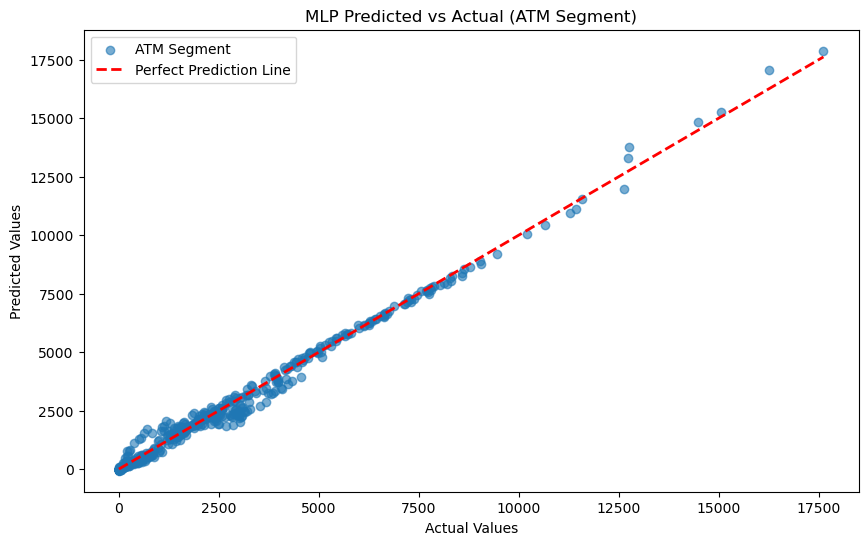

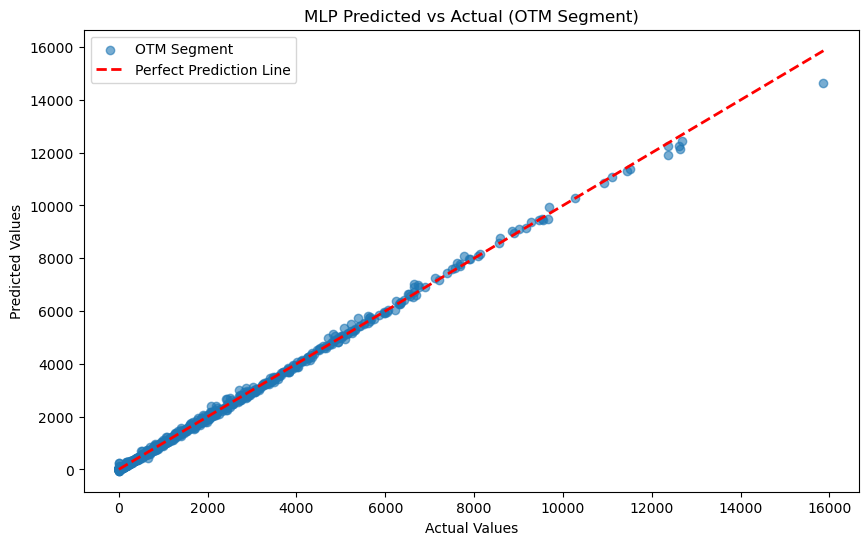

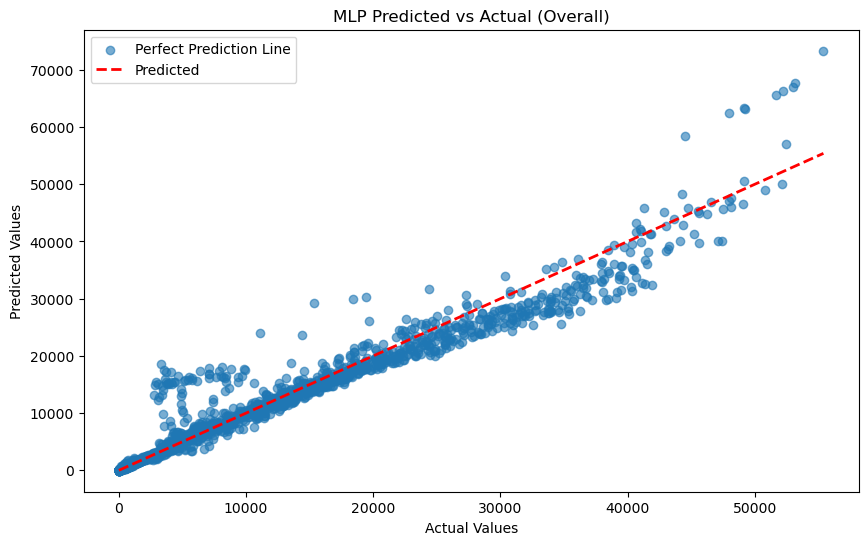

In [19]:
# Predicted vs Actual for each segment
for segment in segments:
    y_test = segment_models[segment]['y_test']
    predictions = segment_models[segment]['predictions']
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.6, label=segment)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
    plt.title(f"MLP Predicted vs Actual ({segment} Segment)")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend([f'{segment} Segment', 'Perfect Prediction Line'])
    plt.show()

y_test_overall = pd.concat([segment_models[segment]['y_test'] for segment in segments])
predictions_overall = np.concatenate([segment_models[segment]['predictions'] for segment in segments])

plt.figure(figsize=(10, 6))
plt.scatter(y_test_overall, predictions_overall, alpha=0.6, label="Predicted")
plt.plot([y_test_overall.min(), y_test_overall.max()], [y_test_overall.min(), y_test_overall.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
plt.title("MLP Predicted vs Actual (Overall)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend(["Perfect Prediction Line", "Predicted"])
plt.show()